<a href="https://colab.research.google.com/github/thinhphan97/mini_project/blob/main/Create_yolo_labels_with_clean_data_by_WBF_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()
# Choose the kaggle.json file that you downloaded

!mkdir '/root/.kaggle'
!cp 'kaggle.json' '/root/.kaggle'
!chmod 600 '/root/.kaggle/kaggle.json'

!kaggle datasets list
# That's all ! You can check if everything's okay by running this command.

In [ ]:
!pip install ensemble-boxes

In [ ]:
!kaggle datasets download -d awsaf49/vinbigdata-512-image-dataset

In [ ]:
!unzip /content/vinbigdata-512-image-dataset.zip

In [56]:
import pandas as pd
from ensemble_boxes import *
train_df = pd.read_csv('/content/vinbigdata/train.csv')
train_df = train_df[train_df.class_id!=14].reset_index(drop = True)
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353
...,...,...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0,2304,2880
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,1163.0,787.0,1338.0,941.0,3072,3072
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0,2048,2500
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,6.0,670.0,272.0,1736.0,2304,2880


###. Helper function

In [25]:
def drawBBox(img_id, df):
    images_dir = '/content/vinbigdata/train/'
    image_path = images_dir + img_id +'.png'
    img = cv2.imread(image_path)
    dh, dw, _ = img.shape

    for index, row in df.iterrows():
        class_name = row['class_name']
        l = int(row['x_min'] * dw)
        r = int(row['x_max'] * dw)
        t = int(row['y_min'] * dh)
        b = int(row['y_max'] * dh)
        color = (0,0,255)
        cv2.putText(img, class_name, (l, t), cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1)
        cv2.rectangle(img, (l, t + 10), (r, b), (255,0,0), 1)

    plt.figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(img)
    plt.show()

In [55]:
def Preprocess_wbf(df, iou_thr = 0.5, skip_box_thr = 0.001):
    list_image = []
    list_boxes = []
    list_cls = []
    new_df = pd.DataFrame()
    for image_id in tqdm(df['image_id'].unique(), leave=False):
        image_df = df[df['image_id'] == image_id].reset_index(drop=True)
        boxes = image_df[['x_min', 'y_min',
                          'x_max', 'y_max']].values.tolist()
        scores = [1.0]*len(boxes)
        labels = [int(i) for i in image_df['class_id'].values]
        boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels],
                                                      weights=None,
                                                      iou_thr=iou_thr,
                                                      skip_box_thr=skip_box_thr)
        
        list_image.extend([image_id]*len(boxes))
        list_boxes.extend(boxes)
        list_cls.extend(labels)
    new_df['image_id'] = list_image
    list_cls = [int(i) for i in list_cls]
    new_df['class_id'] = list_cls
    new_df['x_min'], new_df['y_min'], new_df['x_max'], new_df['y_max'] = np.transpose(list_boxes)
    return new_df

###. Preprocessing

In [57]:
train_df['x_min'] = train_df.apply(lambda row: (row.x_min)/row.width, axis =1)
train_df['y_min'] = train_df.apply(lambda row: (row.y_min)/row.height, axis =1)

train_df['x_max'] = train_df.apply(lambda row: (row.x_max)/row.width, axis =1)
train_df['y_max'] = train_df.apply(lambda row: (row.y_max)/row.height, axis =1)

train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2080,2336
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,0.548611,0.257986,0.699219,0.353819,2304,2880
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,0.246850,0.116211,0.372835,0.140951,2540,3072
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,0.589497,0.095890,0.957549,0.848924,2285,2555
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,0.216900,0.701461,0.262850,0.740829,2568,3353
...,...,...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,0.104167,0.538194,0.243924,0.694792,2304,2880
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,0.378581,0.256185,0.435547,0.306315,3072,3072
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,0.145996,0.265600,0.387695,0.603200,2048,2500
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,0.002604,0.232639,0.118056,0.602778,2304,2880


###. Test bbox

In [35]:
import cv2
test_img_id = '4b56bc6d22b192f075f13231419dfcc8'
image_df = train_df[train_df['image_id'] == test_img_id].reset_index()
image_df

,index,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,77,4b56bc6d22b192f075f13231419dfcc8,Pleural thickening,11,R8,1726.0,1143.0,1842.0,1300.0,1968,2040
1,1776,4b56bc6d22b192f075f13231419dfcc8,Pleural thickening,11,R9,197.0,1192.0,296.0,1370.0,1968,2040
2,3339,4b56bc6d22b192f075f13231419dfcc8,Pleural effusion,10,R9,197.0,1192.0,296.0,1370.0,1968,2040
3,8641,4b56bc6d22b192f075f13231419dfcc8,Aortic enlargement,0,R8,1070.0,392.0,1374.0,756.0,1968,2040
4,9973,4b56bc6d22b192f075f13231419dfcc8,Lung Opacity,7,R10,231.0,1132.0,361.0,1306.0,1968,2040
5,13544,4b56bc6d22b192f075f13231419dfcc8,Pleural effusion,10,R8,1726.0,1143.0,1842.0,1300.0,1968,2040
6,16391,4b56bc6d22b192f075f13231419dfcc8,Pleural effusion,10,R9,1644.0,1036.0,1847.0,1326.0,1968,2040
7,27147,4b56bc6d22b192f075f13231419dfcc8,Lung Opacity,7,R10,1732.0,1139.0,1835.0,1334.0,1968,2040
8,31507,4b56bc6d22b192f075f13231419dfcc8,Aortic enlargement,0,R9,1094.0,408.0,1386.0,721.0,1968,2040
9,31635,4b56bc6d22b192f075f13231419dfcc8,Aortic enlargement,0,R10,1039.0,433.0,1346.0,735.0,1968,2040


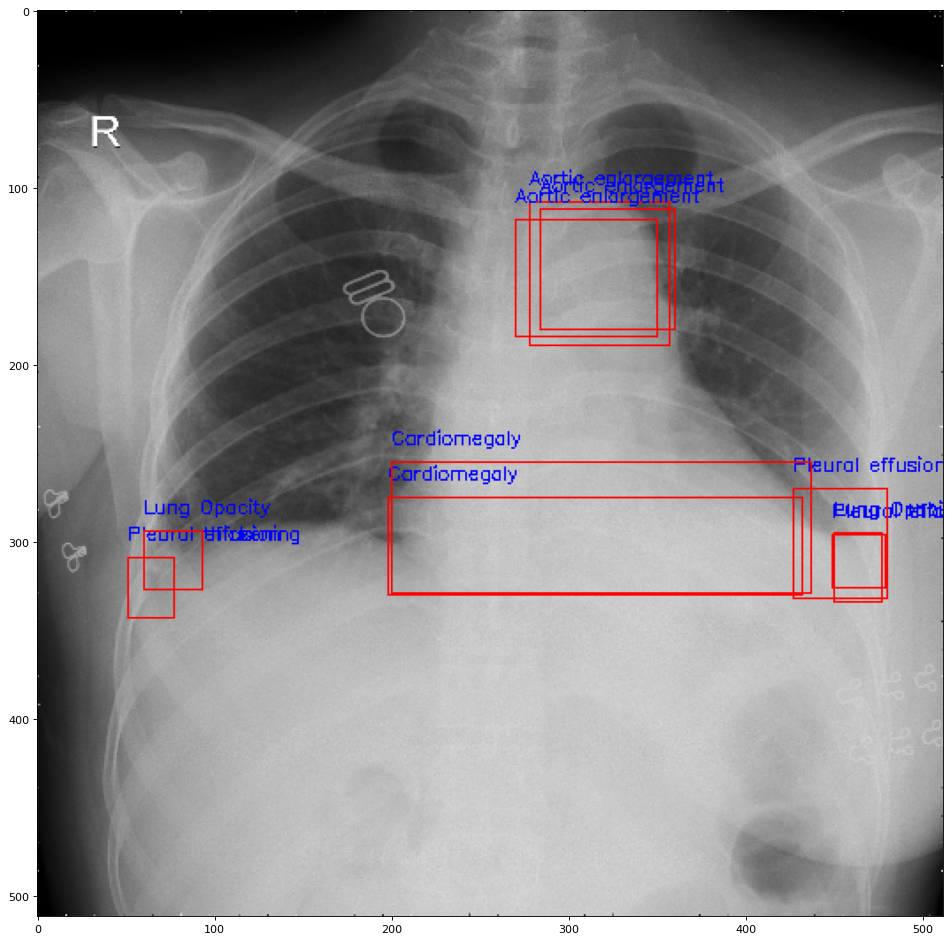

In [24]:
drawBBox(test_img_id, image_df)

### . Preprocess WBF

In [ ]:
train_df = Preprocess_wbf(train_df)

train_df['x_mid'] = train_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

train_df['w'] = train_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_df['h'] = train_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

train_df['area'] = train_df['w']*train_df['h']
train_df

###. Test BBox again

In [59]:
import cv2
test_img_id = '4b56bc6d22b192f075f13231419dfcc8'
image_df = train_df[train_df['image_id'] == test_img_id].reset_index()
image_df

,index,image_id,class_id,x_min,y_min,x_max,y_max,x_mid,y_mid,w,h,area
0,603,4b56bc6d22b192f075f13231419dfcc8,3,0.389990,0.499265,0.849594,0.643627,0.619792,0.571446,0.459604,0.144363,0.066350
1,604,4b56bc6d22b192f075f13231419dfcc8,7,0.117378,0.554902,0.183435,0.640196,0.150407,0.597549,0.066057,0.085294,0.005634
2,605,4b56bc6d22b192f075f13231419dfcc8,7,0.880081,0.558333,0.932419,0.653922,0.906250,0.606127,0.052337,0.095588,0.005003
3,606,4b56bc6d22b192f075f13231419dfcc8,0,0.542514,0.201471,0.695461,0.361438,0.618987,0.281454,0.152947,0.159967,0.024467
4,607,4b56bc6d22b192f075f13231419dfcc8,10,0.100102,0.584314,0.150407,0.671569,0.125254,0.627941,0.050305,0.087255,0.004389
5,608,4b56bc6d22b192f075f13231419dfcc8,10,0.877033,0.560294,0.935976,0.637255,0.906504,0.598775,0.058943,0.076961,0.004536
6,609,4b56bc6d22b192f075f13231419dfcc8,10,0.835366,0.507843,0.938516,0.650000,0.886941,0.578922,0.103150,0.142157,0.014664
7,610,4b56bc6d22b192f075f13231419dfcc8,11,0.877033,0.560294,0.935976,0.637255,0.906504,0.598775,0.058943,0.076961,0.004536
8,611,4b56bc6d22b192f075f13231419dfcc8,11,0.100102,0.584314,0.150407,0.671569,0.125254,0.627941,0.050305,0.087255,0.004389


In [68]:
class_names = {0 : 'Aortic enlargement',
               1 : 'Atelectasis',
               2 : 'Calcification',
               3 : 'Cardiomegaly',
               4 : 'Consolidation',
               5 : 'ILD',
               6 : 'Infiltration',
               7 : 'Lung Opacity',
               8 : 'Nodule/Mass',
               9 : 'Other lesion',
               10 : 'Pleural effusion',
               11 : 'Pleural thickening',
               12 : 'Pneumothorax',
               13 : 'Pulmonary fibrosis'}
class_id_lst = image_df.class_id.tolist()
class_name_list = []
for i in class_id_lst:
    class_name_list.append(class_names[i])
image_df['class_name'] = class_name_list

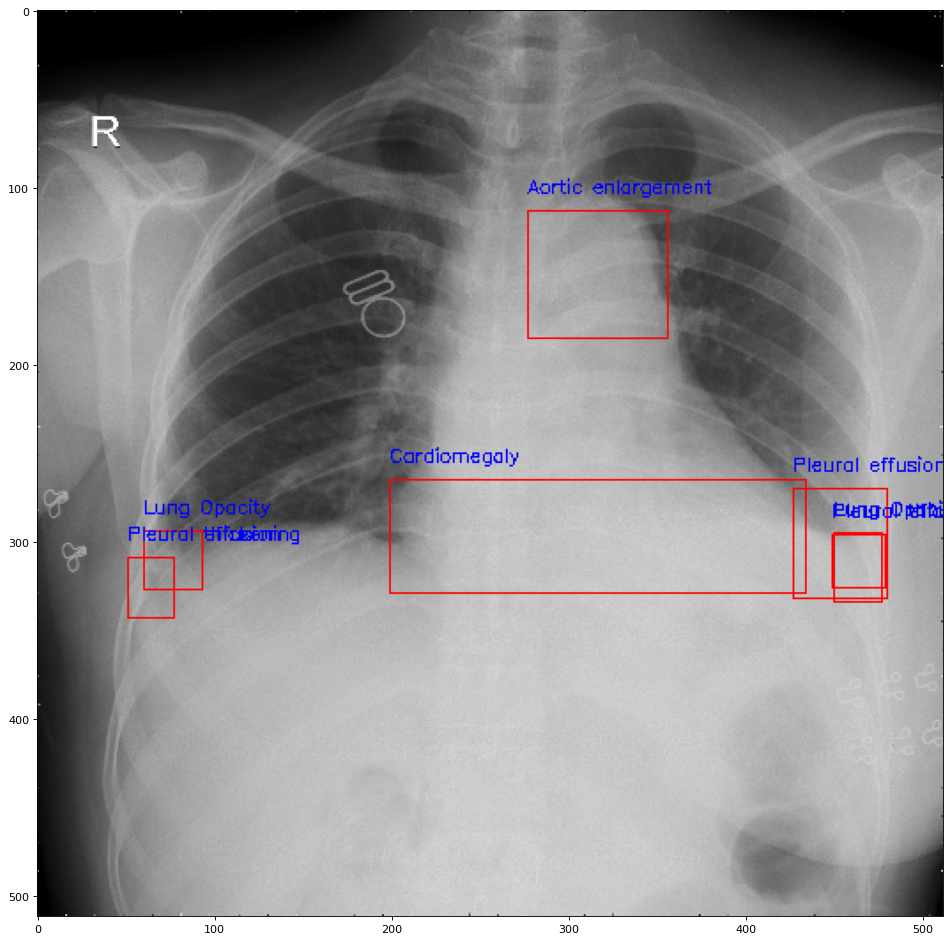

In [69]:
drawBBox(test_img_id, image_df)

### .Creat yolo labels

In [ ]:
images_lst = train_df.groupby('image_id').apply(list).reset_index()['image_id'].tolist()
images_dir = '/content/vinbigdata/train/'

# Add class_id=14 and class_id=15

for img_id in images_lst:
    sub_df = train_df[train_df['image_id'] == img_id].reset_index()
    rows = []
    for index, row in sub_df.iterrows():
        row = [str(row["class_id"]), str(row["x_mid"]), str(row["y_mid"]), str(row["w"]), str(row["h"])]
        rows.append(" ".join(row))
    f = open(images_dir + img_id + ".txt", "w")
    f.write("\n".join(rows))
    f.close()

###. Split K-fold

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import model_selection

train_df["kfold"] = -1

In [ ]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
y = train_df.class_id.values

kf = model_selection.GroupKFold(n_splits=5)

for f, (t_, v_) in enumerate(kf.split(X=train_df, y=y, groups=train_df.image_id.values)): # f: fold, t_ : train, v_ : val
    train_df.loc[v_, "kfold"] = f

In [ ]:
train_df

In [ ]:
train_images_lst = []
val_images_lst   = []
fold = 4
val_images_lst += list(train_df[train_df.kfold==fold].image_id.unique())
train_images_lst += list(train_df[train_df.kfold!=fold].image_id.unique())
len(train_images_lst), len(val_images_lst)

(3516, 878)

In [ ]:
print(train_images_lst)

###. Copy file


In [ ]:
os.makedirs('/labels/train', exist_ok = True)
os.makedirs('/labels/val', exist_ok = True)
os.makedirs('/images/train', exist_ok = True)
os.makedirs('/images/val', exist_ok = True)

In [ ]:
label_dir = '/content/vinbigdata/train/'
# images_train = open('/content/train.txt', 'r')
# images_val = open('/content/val.txt', 'r')

# img_lines = images_train.readlines()

for img in train_images_lst:
    shutil.copy(os.path.join(label_dir, img.strip() +'.png'), '/images/train')
    shutil.copy(os.path.join(label_dir, img.strip() +'.txt'), '/labels/train')


for img in val_images_lst:
    shutil.copy(os.path.join(label_dir, img.strip() +'.png'), '/images/val')
    shutil.copy(os.path.join(label_dir, img.strip() +'.txt'), '/labels/val')


In [ ]:
path = "/images/val"
num_files = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
print(num_files)

878


In [ ]:
path = "/images/train"
num_files = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
print(num_files)

3516


In [ ]:
path = "/labels/train"
num_files = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
print(num_files)

3516


In [ ]:
path = "/labels/val"
num_files = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
print(num_files)

878


In [ ]:
!find /labels/val -type f | wc -l

In [ ]:
!zip -r images.zip '/images'
!zip -r labels.zip '/labels'

In [ ]:
%mv '/content/images.zip' '/content/drive/MyDrive/images.zip'
%mv '/content/labels.zip' '/content/drive/MyDrive/labels.zip'

### n. Ignore item


In [ ]:
def bb_iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou


def averageCoordinates(df, threshold):
    tmp_df = df.reset_index()
    duplicate = {}
    for index1, row1 in tmp_df.iterrows():
        if index1 < len(tmp_df) - 21:
            next_index = index1 + 1
            for index2, row2 in tmp_df.loc[next_index : next_index + 20,:].iterrows():
                if row1["class_id"] == row2["class_id"]:
                    boxA = [row1['x_min'], row1['y_min'], row1['x_max'], row1['y_max']]
                    boxB = [row2['x_min'], row2['y_min'], row2['x_max'], row2['y_max']]
                    iou = bb_iou(boxA, boxB)
                    if iou > threshold:
                        if row1["index"] not in duplicate:
                            duplicate[row1["index"]] = []
                        duplicate[row1["index"]].append(row2["index"])

        if index1 >= len(tmp_df) - 21 and index1 < len(tmp_df) - 1:
            next_index = index1 + 1
            for index2, row2 in tmp_df.loc[next_index : next_index + 20,:].iterrows():
                if row1["class_id"] == row2["class_id"]:
                    boxA = [row1['x_min'], row1['y_min'], row1['x_max'], row1['y_max']]
                    boxB = [row2['x_min'], row2['y_min'], row2['x_max'], row2['y_max']]
                    iou = bb_iou(boxA, boxB)
                    if iou > threshold:
                        if row1["index"] not in duplicate:
                            duplicate[row1["index"]] = []
                        duplicate[row1["index"]].append(row2["index"])

    remove_keys = []
    for k in duplicate:
        for i in duplicate[k]:
            if i in duplicate:
                for id in duplicate[i]:
                    if id not in duplicate[k]:
                        duplicate[k].append(id)
                if i not in remove_keys:
                    remove_keys.append(i)
    for i in remove_keys:
        del duplicate[i]

    rows = []
    removed_index = []
    for k in duplicate:
        row = tmp_df[tmp_df['index'] == k].iloc[0]
        X_min = [row['x_min']]
        X_max = [row['x_max']]
        Y_min = [row['y_min']]
        Y_max = [row['y_max']]
        removed_index.append(k)
        for i in duplicate[k]:
            removed_index.append(i)
            row = tmp_df[tmp_df['index'] == i].iloc[0]
            X_min.append(row['x_min'])
            X_max.append(row['x_max'])
            Y_min.append(row['y_min'])
            Y_max.append(row['y_max'])
        X_min_avg = sum(X_min) / len(X_min)
        X_max_avg = sum(X_max) / len(X_max)
        Y_min_avg = sum(Y_min) / len(Y_min)
        Y_max_avg = sum(Y_max) / len(Y_max)
        new_row = [row['image_id'], row['class_name'], row['class_id'], X_min_avg, Y_min_avg, X_max_avg, Y_max_avg, row['width'], row['height']]
        rows.append(new_row)

    for index, row in tmp_df.iterrows():
        if row['index'] not in removed_index:
            new_row = [row['image_id'], row['class_name'], row['class_id'], row['x_min'], row['y_min'], row['x_max'], row['y_max'], row['width'], row['height']]
            rows.append(new_row)

    new_df = pd.DataFrame(rows, columns =['image_id', 'class_name', 'class_id', 'x_min', 'y_min', 'x_max', 'y_max', 'width', 'height'])
    return new_df


images_lst = df_train.groupby('image_id').apply(list).reset_index()['image_id'].tolist()
print(images_lst)
images_dir = '/content/vinbigdata/train/'

# Add class_id=14 and class_id=15
frames = []
for img_id in images_lst:
    sub_df = df_train[df_train['image_id'] == img_id].reset_index()
    sub_df = averageCoordinates(sub_df,  0.5)
    frames.append(sub_df)
    rows = []
    if int(sub_df["class_id"][0]) == 14:
        rows.append("14 0.5 0.5 1.0 1.0") # A box that cover whole the image
    else:
        for index, row in sub_df.iterrows():
            w = int(row["width"])
            h = int(row["height"])
            cx = (int(row["x_min"]) + int(row["x_max"])) / 2 / w
            cy = (int(row["y_min"]) + int(row["y_max"])) / 2 / h
            bw = (int(row["x_max"]) - int(row["x_min"])) / w
            bh = (int(row["y_max"]) - int(row["y_min"])) / h
            row = [str(row["class_id"]), str(cx), str(cy), str(bw), str(bh)]
            rows.append(" ".join(row))
        rows.append("15 0.5 0.5 1.0 1.0")  # A box that cover whole the image
    f = open(images_dir + img_id + ".txt", "w")
    f.write("\n".join(rows))
    f.close()

new_df = pd.concat(frames)

['000434271f63a053c4128a0ba6352c7f', '00053190460d56c53cc3e57321387478', '0005e8e3701dfb1dd93d53e2ff537b6e', '0006e0a85696f6bb578e84fafa9a5607', '0007d316f756b3fa0baea2ff514ce945', '000ae00eb3942d27e0b97903dd563a6e', '000d68e42b71d3eac10ccc077aba07c1', '00150343289f317a0ad5629d5b7d9ef9', '00176f7e1b1cb835123f95960b9a9efd', '001d127bad87592efe45a5c7678f8b8d', '0021df30f3fddef551eb3df4354b1d06', '00291f7aff0123ea76a59998effef229', '0032c6091dc8f1b1245fc2f5f45458fa', '003cfe5ce5c0ec5163138eb3b740e328', '0046f681f078851293c4e710c4466058', '004d2bc2111d639f5e8441ced52d55cb', '004dc2a50591fb5f1aaf012bffa95fd9', '00575e3846ebd05a909d97ba59c53d30', '0059d21bef1793fa9522e4ec8cae1a1a', '005be26a68485912e007a3703f43d60a', '005d70155f949c7785671800f2c8e1ca', '0061cf6d35e253b6e7f03940592cc35e', '006501b11e04aec2d403177b9ae0f34c', '00675cd546313f912cadd4ad54415d69', '006e2726c6aa72f042a08b1406c39d52', '006e5626f560c1a2a74f953d71f16c11', '0071fbed56e53f6bfe416b7558b31f98', '0076d6a1e3139927fd62459c54

In [ ]:
new_df = new_df.drop_duplicates(ignore_index=True)
new_df.to_csv('/content/vinbigdata/new_train.csv', index=False)
new_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height
0,000434271f63a053c4128a0ba6352c7f,No finding,14,NaN,NaN,NaN,NaN,2336,2836
1,00053190460d56c53cc3e57321387478,No finding,14,NaN,NaN,NaN,NaN,1994,2430
2,0005e8e3701dfb1dd93d53e2ff537b6e,Lung Opacity,7,902.5,585.0,1204.0,889.000000,3072,3072
3,0005e8e3701dfb1dd93d53e2ff537b6e,Nodule/Mass,8,932.0,567.0,1197.0,896.000000,3072,3072
4,0005e8e3701dfb1dd93d53e2ff537b6e,Infiltration,6,900.0,587.0,1205.0,888.000000,3072,3072
...,...,...,...,...,...,...,...,...,...
34459,ffe6f9fe648a7ec29a50feb92d6c15a4,Other lesion,9,563.0,1148.0,593.0,1185.000000,2685,2857
34460,ffea246f04196af602c7dc123e5e48fc,No finding,14,NaN,NaN,NaN,NaN,1994,2430
34461,ffeffc54594debf3716d6fcd2402a99f,Aortic enlargement,0,1255.0,756.0,1567.0,1155.333333,2464,2944
34462,fff0f82159f9083f3dd1f8967fc54f6a,No finding,14,NaN,NaN,NaN,NaN,2048,2500


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import model_selection

df_train = pd.read_csv('/content/vinbigdata/new_train.csv')

df_train["kfold"] = -1

In [ ]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
y = df_train.class_id.values

kf = model_selection.GroupKFold(n_splits=5)

for f, (t_, v_) in enumerate(kf.split(X=df_train, y=y, groups=df_train.image_id.values)): # f: fold, t_ : train, v_ : val
    df_train.loc[v_, "kfold"] = f

In [ ]:
df_train

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,width,height,kfold
0,828c239be4afbb409fc1c190360a73c9,Infiltration,6,332.0,1313.000000,669.0,1545.000000,2016,2264,3
1,0ac383fcdc6f1957b3ecceaf0acec909,Nodule/Mass,8,1845.0,1911.000000,1888.0,1962.000000,2304,2880,2
2,ef8c3f4f4d6b6d278abdbc8077051629,Other lesion,9,708.0,679.000000,1172.0,949.000000,3096,2444,0
3,757b9dce1ec83ee0758ebbac0fc6461a,Cardiomegaly,3,693.0,1389.666667,1813.0,1734.333333,2304,2880,3
4,dc7d6c6fa1fdde25e0aa64a1f6fd594a,Pleural thickening,11,513.0,736.000000,874.0,1051.000000,2304,2880,0
...,...,...,...,...,...,...,...,...,...,...
34459,fe9ae553a2fa76cba207ebd4b9b0cddb,Pleural thickening,11,772.0,519.000000,1031.0,581.000000,2511,2687,3
34460,fb8e11c6b2886b2d41b379e0598669b9,Lung Opacity,7,597.0,1445.000000,933.0,1756.000000,2304,2880,0
34461,63382fd6688255077d3e61f946fa8c35,Aortic enlargement,0,1532.0,808.500000,1813.5,1159.000000,2859,2653,4
34462,fae699d3040cd12803b71691b279a6b6,No finding,14,NaN,NaN,NaN,NaN,2517,3028,0


In [ ]:
train_images_lst = []
val_images_lst   = []
fold = 4
val_images_lst += list(df_train[df_train.kfold==fold].image_id.unique())
train_images_lst += list(df_train[df_train.kfold!=fold].image_id.unique())
len(train_images_lst), len(val_images_lst)

(12000, 3000)

In [ ]:
def createImagesTxt(_images, filepath):
    images_dir = '/content/vinbigdata/train/'
    rows = []
    for img_id in _images:
        rows.append(images_dir + img_id + '.png')
        print("add " + images_dir, img_id)
    f = open(filepath, "w+")
    f.write("\n".join(rows))
    f.close()

train_path = '/content/train.txt'
val_path = '/content/val.txt'
createImagesTxt(train_images_lst, train_path)
createImagesTxt(val_images_lst, val_path)